#빅데이터 프로젝트: 2000–2025 음악 장르 트렌드 분석

In [19]:
import pandas as pd
csv_path = "/content/drive/MyDrive/bigDataProject/data/billboard_24years_lyrics_spotify.csv"

df = pd.read_csv(csv_path)
billboard = df[['ranking', 'song', 'band_singer', 'year']].copy()

billboard.head(3)  # 미리보기
billboard.info()   # 컬럼/결측치 확인



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ranking      3397 non-null   int64 
 1   song         3397 non-null   object
 2   band_singer  3397 non-null   object
 3   year         3397 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 106.3+ KB


In [20]:
artists = pd.Series(sorted(billboard['band_singer'].dropna().unique()), name="artist")
print(f"고유 아티스트 수: {len(artists)}")
print(artists.head(10))  # 상위 10명 미리보기


고유 아티스트 수: 1039
0         'N Sync
1       070 Shake
2             112
3        2 Chainz
4       2 Pistols
5       21 Savage
6        24kGoldn
7            2Pac
8    3 Doors Down
9             3LW
Name: artist, dtype: object


In [21]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 11.3 MB/s eta 0:00:00


Spotify API로 아티스트 장르 정보를 반복적으로 요청하면 시간이 오래 걸리기 때문에,  
이미 조회한 아티스트의 장르 정보는 JSON 파일로 저장하여 캐시 형태로 재사용하였다.  
아래 코드는 캐시 디렉터리를 생성하고, 캐시 파일이 존재하면 불러오며,  
없을 경우 빈 캐시를 새로 생성한다.

In [23]:
# 캐시 파일 준비 (저장할 폴더 및 파일 생성)

import os, json
from pathlib import Path

# 캐시 저장 경로
cache_dir = Path("/content/drive/MyDrive/bigDataProject/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
cache_path = cache_dir / "artist_genre_cache.json"

# 캐시 파일이 존재하면 불러오기, 없으면 새로 생성
if cache_path.exists():
    with open(cache_path, "r", encoding="utf-8") as f:
        genre_cache = json.load(f)
    print(f"기존 캐시 불러옴 ({len(genre_cache)}명)")
else:
    genre_cache = {}
    print("새 캐시 파일 생성")


새 캐시 파일 생성


In [24]:
import getpass
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify api 인증 정보 입력
CLIENT_ID = getpass.getpass("SPOTIFY_CLIENT_ID: ")
CLIENT_SECRET = getpass.getpass("SPOTIFY_CLIENT_SECRET: ")

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET
    )
)


SPOTIFY_CLIENT_ID: ··········
SPOTIFY_CLIENT_SECRET: ··········


In [25]:
def make_search_name(name: str) -> str:
    # 앞뒤 공백 제거
    cleaned = name.strip()
    # 앞뒤 따옴표 제거
    cleaned = cleaned.strip("'").strip('"').strip("’").strip("‘")


    return cleaned

# 변환 결과 확인
samples = ["'N Sync", " Adele ", "Adam Levine", "3 Doors Down"]
for s in samples:
    print(f"원래: {s!r}  →  검색용: {make_search_name(s)!r}")


원래: "'N Sync"  →  검색용: 'N Sync'
원래: ' Adele '  →  검색용: 'Adele'
원래: 'Adam Levine'  →  검색용: 'Adam Levine'
원래: '3 Doors Down'  →  검색용: '3 Doors Down'


In [26]:
import time, random

print("전체 자동 수집 시작…")
remaining = [a for a in artists if a not in genre_cache]
print("남은 아티스트 수:", len(remaining))

for i, name in enumerate(remaining, start=1):
    # 검색용 이름 정리
    qname = make_search_name(name)

    # Spotify에서 아티스트 정보 조회
    res = sp.search(q=qname, type="artist", limit=1)
    items = res.get("artists", {}).get("items", [])
    genres = items[0].get("genres", []) if items else []

    # 조회한 장르를 캐시에 저장
    genre_cache[name] = genres

    # 진행 상황 출력 및 중간 저장
    if i % 50 == 0 or i == len(remaining):
        print(f"{i}/{len(remaining)} 완료: {name} → {genres}")

        # 중간 저장
        with open("/content/drive/MyDrive/bigDataProject/cache/artist_genre_cache.json", "w", encoding="utf-8") as f:
            json.dump(genre_cache, f, ensure_ascii=False)
        print("중간 저장 완료")

    # 속도 제한 회피
    time.sleep(random.uniform(0.4, 0.5))

print("전체 장르 수집 완료")


전체 자동 수집 시작…
남은 아티스트 수: 1039
50/1039 완료: Anderson .Paak → []
중간 저장 완료
100/1039 완료: Bizarrap → ['argentine trap', 'trap latino', 'urbano latino']
중간 저장 완료
150/1039 완료: Carly Pearce → ['country']
중간 저장 완료
200/1039 완료: Corey Kent → ['country', 'texas country']
중간 저장 완료
250/1039 완료: Dido → []
중간 저장 완료
300/1039 완료: Evan and Jaron → []
중간 저장 완료
350/1039 완료: Ginuwine → ['r&b']
중간 저장 완료
400/1039 완료: J Balvin → ['reggaeton', 'latin']
중간 저장 완료
450/1039 완료: Jim Jones → []
중간 저장 완료
500/1039 완료: Kenny Chesney → ['country']
중간 저장 완료
550/1039 완료: Leighton Meester → []
중간 저장 완료
600/1039 완료: Mac Miller → []
중간 저장 완료
650/1039 완료: Missy Elliott → ['hip hop']
중간 저장 완료
700/1039 완료: Nickelback → ['post-grunge', 'rock']
중간 저장 완료
750/1039 완료: Pharrell Williams → []
중간 저장 완료
800/1039 완료: Rihanna → []
중간 저장 완료
850/1039 완료: Shakira → ['latin pop']
중간 저장 완료
900/1039 완료: T.I. → ['southern hip hop']
중간 저장 완료
950/1039 완료: Toosii → []
중간 저장 완료
1000/1039 완료: Wizkid → ['afrobeats', 'afrobeat', 'afropop', 'azonto', 'afr

In [27]:
import pandas as pd

# 장르 캐시를 데이터프레임 형태로 변환
rows = [
    {"artist": k, "genres": (v if isinstance(v, list) else [])}
    for k, v in genre_cache.items()
]

genre_df = pd.DataFrame(rows)

print("캐시에 있는 아티스트 수:", len(genre_df))
genre_df.head(10)


캐시에 있는 아티스트 수: 1039


,artist,genres
0,'N Sync,[]
1,070 Shake,[]
2,112,[r&b]
3,2 Chainz,"[rap, southern hip hop]"
4,2 Pistols,[]
5,21 Savage,[]
6,24kGoldn,[]
7,2Pac,"[old school hip hop, gangster rap, west coast ..."
8,3 Doors Down,[post-grunge]
9,3LW,[]


In [28]:
# 대표 장르 만들기
import re

# 아티스트 장르 목록의 첫 번째 값을 사용해 대표 장르 생성
genre_df["genre_primary"] = genre_df["genres"].apply(
    lambda g: g[0].lower() if isinstance(g, list) and len(g) > 0 else "unknown"
)

# 세부 장르명을 대분류로 변환
def map_coarse(genre):
    if not isinstance(genre, str):
        return "other"
    g = genre.lower()

    if re.search(r'k[-\s]?pop', g):
        return "k-pop"
    if re.search(r'hip[-\s]?hop|rap|trap', g):
        return "hip hop"
    if re.search(r'r&b|soul', g):
        return "r&b"
    if re.search(r'rock|metal|punk', g):
        return "rock"
    if re.search(r'edm|electro|dance|house', g):
        return "edm"
    if re.search(r'latin|reggaeton', g):
        return "latin"
    if re.search(r'j[-\s]?pop', g):
        return "j-pop"
    if "pop" in g:
        return "pop"
    if g == "unknown":
        return "unknown"
    return "other"

genre_df["genre_coarse"] = genre_df["genre_primary"].apply(map_coarse)

genre_df.head(20)


,artist,genres,genre_primary,genre_coarse
0,'N Sync,[],unknown,unknown
1,070 Shake,[],unknown,unknown
2,112,[r&b],r&b,r&b
3,2 Chainz,"[rap, southern hip hop]",rap,hip hop
4,2 Pistols,[],unknown,unknown
5,21 Savage,[],unknown,unknown
6,24kGoldn,[],unknown,unknown
7,2Pac,"[old school hip hop, gangster rap, west coast ...",old school hip hop,hip hop
8,3 Doors Down,[post-grunge],post-grunge,other
9,3LW,[],unknown,unknown


In [29]:
# billboard 컬럼 이름 정리 (merge를 위해 artist로 통일)
billboard_merge = billboard.rename(columns={
    "band_singer": "artist",
    "ranking": "rank",
    "song": "title"
})

billboard_merge.head(10)


,rank,title,artist,year
0,1,Breathe,Faith Hill,2000
1,2,Smooth,Santana,2000
2,2,Smooth,Rob Thomas,2000
3,3,Maria Maria,Santana,2000
4,3,Maria Maria,The Product G&B,2000
5,4,I Wanna Know,Joe,2000
6,5,Everything You Want,Vertical Horizon,2000
7,6,Say My Name,Destiny's Child,2000
8,7,I Knew I Loved You,Savage Garden,2000
9,8,Amazed,Lonestar,2000


같은 곡이라도 참여한 아티스트가 여러 명이면,
원본 데이터에서 아티스트별로 한 줄씩 나누어 저장되어 있다.
따라서 rank, title이 동일하지만 artist만 다른 중복 행이 존재한다.

In [30]:
# billboard 데이터에  아티스트 장르 정보 병합
billboard_with_genre = billboard_merge.merge(
    genre_df[["artist", "genre_primary", "genre_coarse"]],
    on="artist",
    how="left")

billboard_with_genre.head(10)


,rank,title,artist,year,genre_primary,genre_coarse
0,1,Breathe,Faith Hill,2000,country,other
1,2,Smooth,Santana,2000,unknown,unknown
2,2,Smooth,Rob Thomas,2000,unknown,unknown
3,3,Maria Maria,Santana,2000,unknown,unknown
4,3,Maria Maria,The Product G&B,2000,unknown,unknown
5,4,I Wanna Know,Joe,2000,unknown,unknown
6,5,Everything You Want,Vertical Horizon,2000,unknown,unknown
7,6,Say My Name,Destiny's Child,2000,unknown,unknown
8,7,I Knew I Loved You,Savage Garden,2000,unknown,unknown
9,8,Amazed,Lonestar,2000,country,other


In [31]:
# 장르가 unknown인 곡 수와 비율 확인
total = len(billboard_with_genre)
unknown_cnt = (billboard_with_genre["genre_primary"] == "unknown").sum()

print("전체 곡 수:", total)
print("장르 unknown 곡 수:", unknown_cnt)
print("비율(%) :", round(unknown_cnt / total * 100, 2))


전체 곡 수: 3397
장르 unknown 곡 수: 1618
비율(%) : 47.63


In [32]:
print("고유 아티스트 수:", billboard_with_genre["artist"].nunique())
print("총 곡 수:", len(billboard_with_genre))


고유 아티스트 수: 1039
총 곡 수: 3397


In [33]:
billboard_with_genre.columns


Index(['rank', 'title', 'artist', 'year', 'genre_primary', 'genre_coarse'], dtype='object')

In [34]:
output_path = "/content/drive/MyDrive/bigDataProject/data/billboard_with_genre.csv"
billboard_with_genre.to_csv(output_path, index=False, encoding="utf-8-sig")

print("CSV 저장 완료:", output_path)


CSV 저장 완료: /content/drive/MyDrive/bigDataProject/data/billboard_with_genre.csv


In [35]:
# 연도별로 unknown 곡 수와 전체 곡 수 집계
year_unknown = billboard_with_genre.groupby("year")["genre_primary"].apply(
    lambda x: (x == "unknown").sum()
)

year_total = billboard_with_genre.groupby("year")["genre_primary"].count()

# 하나의 표로 정리
year_stats = pd.DataFrame({
    "unknown_count": year_unknown,
    "total_count": year_total
})

year_stats.head(24)


,unknown_count,total_count
year,,
2000,46,115
2001,46,125
2002,48,134
2003,50,142
2004,53,141
2005,46,140
2006,58,141
2007,71,142
2008,78,139


여기까지가 빌보드 부분


# 여기서부터 2025

In [36]:
import glob
import pandas as pd

folder = "/content/drive/MyDrive/bigDataProject/spotify_2025"  # 43개 csv 있는 폴더
files = sorted(glob.glob(folder + "/*.csv"))

print("파일 개수:", len(files))
print("앞 3개 파일:", files[:3])


파일 개수: 43
앞 3개 파일: ['/content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-09.csv', '/content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-16.csv', '/content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-23.csv']


In [37]:
# 첫 CSV만 열어서 구조 확인
sample = pd.read_csv(files[0])
print("샘플 파일:", files[0])
print(sample.shape)
print(sample.columns)
sample.head()


샘플 파일: /content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-09.csv
(200, 9)
Index(['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank',
       'previous_rank', 'weeks_on_chart', 'streams'],
      dtype='object')


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams
0,1,spotify:track:2plbrEY59IikOBgBGLjaoe,"Lady Gaga, Bruno Mars",Die With A Smile,Interscope,1,1,21,70779585
1,2,spotify:track:4wJ5Qq0jBN4ajy7ouZIV1c,"ROSÉ, Bruno Mars",APT.,"Atlantic Records, THEBLACKLABEL",1,2,12,64078762
2,3,spotify:track:7ne4VBA60CxGM75vw0EYad,Gracie Abrams,That’s So True,"Gracie Abrams, under exclusive license to Inte...",3,4,12,47295577
3,4,spotify:track:6dOtVTDdiauQNBQEDOtlAB,Billie Eilish,BIRDS OF A FEATHER,Darkroom/Interscope Records,1,3,34,46903880
4,5,spotify:track:7tI8dRuH2Yc6RuoTjxo4dU,Jimin,Who,BIGHIT MUSIC,1,5,25,32153248


In [38]:
import pandas as pd
import glob


folder = "/content/drive/MyDrive/bigDataProject/spotify_2025"

# 폴더 안의 csv 파일 목록 가져오기
files = sorted(glob.glob(folder + "/*.csv"))

print("파일 개수:", len(files))
print("앞 3개 파일:", files[:3])

# CSV 파일들 전부 읽어서 하나로 합치기
df_list = [pd.read_csv(f) for f in files]
df_2025_raw = pd.concat(df_list, ignore_index=True)

print("합친 후 전체 데이터 크기:", df_2025_raw.shape)
print(df_2025_raw.columns)
df_2025_raw.head()


파일 개수: 43
앞 3개 파일: ['/content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-09.csv', '/content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-16.csv', '/content/drive/MyDrive/bigDataProject/spotify_2025/regional-global-weekly-2025-01-23.csv']
합친 후 전체 데이터 크기: (8600, 9)
Index(['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank',
       'previous_rank', 'weeks_on_chart', 'streams'],
      dtype='object')


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams
0,1,spotify:track:2plbrEY59IikOBgBGLjaoe,"Lady Gaga, Bruno Mars",Die With A Smile,Interscope,1,1,21,70779585
1,2,spotify:track:4wJ5Qq0jBN4ajy7ouZIV1c,"ROSÉ, Bruno Mars",APT.,"Atlantic Records, THEBLACKLABEL",1,2,12,64078762
2,3,spotify:track:7ne4VBA60CxGM75vw0EYad,Gracie Abrams,That’s So True,"Gracie Abrams, under exclusive license to Inte...",3,4,12,47295577
3,4,spotify:track:6dOtVTDdiauQNBQEDOtlAB,Billie Eilish,BIRDS OF A FEATHER,Darkroom/Interscope Records,1,3,34,46903880
4,5,spotify:track:7tI8dRuH2Yc6RuoTjxo4dU,Jimin,Who,BIGHIT MUSIC,1,5,25,32153248


In [39]:
# uri 기준 중복 상황 확인
total_rows = len(df_2025_raw)
unique_uri = df_2025_raw["uri"].nunique()

print("전체 행 수:", total_rows)
print("고유 uri 개수:", unique_uri)
print("중복된 uri 개수:", total_rows - unique_uri)

# uri 기준으로 중복 제거해서 고유 곡 테이블 만들기
df_2025_unique = df_2025_raw.drop_duplicates(subset="uri").copy()

print("중복 제거 후 df_2025_unique.shape:", df_2025_unique.shape)
df_2025_unique.head()


전체 행 수: 8600
고유 uri 개수: 817
중복된 uri 개수: 7783
중복 제거 후 df_2025_unique.shape: (817, 9)


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams
0,1,spotify:track:2plbrEY59IikOBgBGLjaoe,"Lady Gaga, Bruno Mars",Die With A Smile,Interscope,1,1,21,70779585
1,2,spotify:track:4wJ5Qq0jBN4ajy7ouZIV1c,"ROSÉ, Bruno Mars",APT.,"Atlantic Records, THEBLACKLABEL",1,2,12,64078762
2,3,spotify:track:7ne4VBA60CxGM75vw0EYad,Gracie Abrams,That’s So True,"Gracie Abrams, under exclusive license to Inte...",3,4,12,47295577
3,4,spotify:track:6dOtVTDdiauQNBQEDOtlAB,Billie Eilish,BIRDS OF A FEATHER,Darkroom/Interscope Records,1,3,34,46903880
4,5,spotify:track:7tI8dRuH2Yc6RuoTjxo4dU,Jimin,Who,BIGHIT MUSIC,1,5,25,32153248


In [40]:
import pandas as pd

# 스트림 값이 문자열로 들어온 경우를 대비해서 숫자로 변환
df_2025_raw["streams"] = pd.to_numeric(df_2025_raw["streams"], errors="coerce")

df_2025_raw[["streams"]].head()

# uri 기준으로 곡 단위 요약 정보 생성
songs_2025_base = (
    df_2025_raw
    .groupby("uri")
    .agg(
        track_name    = ("track_name", "first"),   # 곡 제목
        artist_names  = ("artist_names", "first"), # 아티스트 병합 문자열
        source        = ("source", "first"),       # 데이터 출처
        streams_total = ("streams", "sum"),        # 연간 총 스트리밍
        weeks_total   = ("weeks_on_chart", "max"), # 차트 진입 주 수
        best_rank     = ("rank", "min"),           # 기록된 순위 중 최고 순위
        best_peak_rank = ("peak_rank", "min"),     # 피크 순위 중 최솟값(최고 성적)
    )
    .reset_index()
)

# uri를 분석용 song_id로 변경
songs_2025_base = songs_2025_base.rename(columns={"uri": "song_id"})

# 연도 정보 추가
songs_2025_base["year"] = 2025

print(songs_2025_base.shape)
songs_2025_base.head(10)



(817, 9)


,song_id,track_name,artist_names,source,streams_total,weeks_total,best_rank,best_peak_rank,year
0,spotify:track:003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers,Island Records,399317435,192,112,94,2025
1,spotify:track:00iLTetTLAeImmBlh6jOJh,K POP,Playboi Carti,AWGE/Interscope Records,17489185,1,42,42,2025
2,spotify:track:0129EujhGkwtwTFADGem5P,Wood,Taylor Swift,Taylor Swift,65988612,1,5,5,2025
3,spotify:track:01p5urrGw5fuFCcfT7PBgc,GO BABY,Justin Bieber,"JRC Entertainment, LLC / ILH Production Co. LL...",42770265,3,15,15,2025
4,spotify:track:01qFKNWq73UfEslI0GvumE,3D (feat. Jack Harlow),"Jung Kook, Jack Harlow",BIGHIT MUSIC,34591928,34,146,3,2025
5,spotify:track:02BcXEH1zJYbXSabPtNlKf,Lose My Mind (feat. Doja Cat) [From F1® The Mo...,"Don Toliver, Doja Cat, F1 The Album",Atlantic Records,80709289,8,71,71,2025
6,spotify:track:02Ya2Q08bBKFqUJvjmyRXK,Just In Case,Morgan Wallen,Mercury Records/Morgan Wallen,65625478,7,105,105,2025
7,spotify:track:02sy7FAs8dkDNYsHp4Ul3f,Soda Pop,"Saja Boys, Andrew Choi, Neckwav, Danny Chung, ...",K-Pop Demon Hunters,479981764,19,4,4,2025
8,spotify:track:03JZr55j9bIj1d2RQJ7Yq9,Jealous Type,Doja Cat,Kemosabe Records/RCA Records,9107470,5,144,36,2025
9,spotify:track:03bTIHJElXZ0O0jqOQvAbY,Father Figure,Taylor Swift,Taylor Swift,79490247,4,5,4,2025


In [41]:
import pandas as pd

# song_id와 artist_names만 사용
song_artist_2025 = songs_2025_base[["song_id", "artist_names"]].copy()

# artist_names를 콤마 기준으로 리스트로 나누기
song_artist_2025["artist_raw"] = song_artist_2025["artist_names"].str.split(",")

# 여러 아티스트가 묶여 있는 값을 각각의 행으로 분리
song_artist_2025 = song_artist_2025.explode("artist_raw")

# 빈 값/NaN 제거
song_artist_2025 = song_artist_2025.dropna(subset=["artist_raw"])

# 앞뒤 공백 제거
song_artist_2025["artist_raw"] = song_artist_2025["artist_raw"].str.strip()

print(song_artist_2025.shape)
song_artist_2025.head(10)


# Spotify 검색 정확도를 높이기 위해 아티스트 이름을 정제
def make_search_name(name: str) -> str:
    if not isinstance(name, str):
        return ""
    cleaned = name.strip()
    cleaned = cleaned.strip("'").strip('"').strip("’").strip("‘")



    return cleaned



song_artist_2025["artist_clean"] = song_artist_2025["artist_raw"].apply(make_search_name)

song_artist_2025.head(10)


artists_2025 = sorted(
    song_artist_2025["artist_clean"]
    .dropna()
    .unique()
)

print("2025년에 등장한 고유 아티스트 수:", len(artists_2025))
artists_2025[:30]



(1251, 3)
2025년에 등장한 고유 아티스트 수: 526


['.Feast',
 '21 Savage',
 'AC/DC',
 'AFROJACK',
 'AP Dhillon',
 'ATL Jacob',
 'ATLXS',
 'AUDREY NUNA',
 'AZ Chike',
 'Abor & Tynna',
 'Achille Lauro',
 'Adam Port',
 'Addison Rae',
 'Adele',
 'Aditya Rikhari',
 'Aditya Sharma',
 'Adrian Khalif',
 'Afusic',
 'Alef Donk',
 'Alemán',
 'Alex Krack',
 'Alex Warren',
 'AliSoomroMusic',
 'Alleh',
 'Amarabha Banerjee',
 'Andmesh',
 'Andrew Choi',
 'Anitta',
 'Annural Khalid',
 'Anuel AA']

In [42]:
import getpass
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

CLIENT_ID = getpass.getpass("SPOTIFY_CLIENT_ID: ")
CLIENT_SECRET = getpass.getpass("SPOTIFY_CLIENT_SECRET: ")

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET
    )
)

print("Spotify client 준비 완료")


SPOTIFY_CLIENT_ID: ··········
SPOTIFY_CLIENT_SECRET: ··········
Spotify client 준비 완료


In [43]:
import json
from pathlib import Path

cache_path = Path("/content/drive/MyDrive/bigDataProject/cache/artist_genre_cache.json")

if cache_path.exists():
    with open(cache_path, "r", encoding="utf-8") as f:
        genre_cache = json.load(f)
    print("기존 장르 캐시 불러옴")
    print("캐시에 저장된 아티스트 수:", len(genre_cache))
else:
    print("캐시 파일이 없습니다. 새로 시작합니다.")
    genre_cache = {}


# 캐시에 없는 2025년 아티스트만 따로 뽑기
new_artists_2025 = [a for a in artists_2025 if a not in genre_cache]

print("2025 아티스트 전체 수:", len(artists_2025))
print("이미 캐시에 있는 아티스트 수:", len(artists_2025) - len(new_artists_2025))
print("이번에 새로 장르를 받아와야 하는 아티스트 수:", len(new_artists_2025))

# 앞 20명만 확인
new_artists_2025[:20]




기존 장르 캐시 불러옴
캐시에 저장된 아티스트 수: 1039
2025 아티스트 전체 수: 526
이미 캐시에 있는 아티스트 수: 130
이번에 새로 장르를 받아와야 하는 아티스트 수: 396


['.Feast',
 'AC/DC',
 'AFROJACK',
 'AP Dhillon',
 'ATL Jacob',
 'ATLXS',
 'AUDREY NUNA',
 'AZ Chike',
 'Abor & Tynna',
 'Achille Lauro',
 'Adam Port',
 'Addison Rae',
 'Aditya Rikhari',
 'Aditya Sharma',
 'Adrian Khalif',
 'Afusic',
 'Alef Donk',
 'Alemán',
 'Alex Krack',
 'Alex Warren']

In [44]:
import time, random


#아티스트 한 명의 장르를 검색해서 캐시에 저장
def fetch_genres_for_artist(name: str):

    # 이미 캐시에 있으면 그대로 사용
    if name in genre_cache and isinstance(genre_cache[name], list):
        return genre_cache[name]

    # 검색용 이름 정리
    qname = make_search_name(name)

    # Spotify에서 아티스트 정보 조회
    res = sp.search(q=qname, type="artist", limit=1)
    items = res.get("artists", {}).get("items", [])
    genres = items[0].get("genres", []) if items else []

    # 조회한 장르를 캐시에 저장
    genre_cache[name] = genres

    return genres



print("2025 새 아티스트 장르 수집 시작…")
print("총 새 아티스트 수:", len(new_artists_2025))

for i, artist in enumerate(new_artists_2025, start=1):
    g = fetch_genres_for_artist(artist)

    # 진행 상황 출력 및 중간 저장
    if i % 20 == 0 or i == len(new_artists_2025):
        print(f"{i}/{len(new_artists_2025)} 완료: {artist} → {g}")

        # 중간 저장
        with open(cache_path, "w", encoding="utf-8") as f:
            json.dump(genre_cache, f, ensure_ascii=False)
        print("중간 캐시 저장 완료")

    # 속도 제한 회피
    time.sleep(random.uniform(0.3, 0.5))

print("2025 새 아티스트 장르 수집 완료")





2025 새 아티스트 장르 수집 시작…
총 새 아티스트 수: 396
20/396 완료: Alex Warren → []
중간 캐시 저장 완료
40/396 완료: BLACKPINK → ['k-pop']
중간 캐시 저장 완료
60/396 완료: Chase Atlantic → []
중간 캐시 저장 완료
80/396 완료: DJ Javi26 → ['phonk', 'brazilian phonk']
중간 캐시 저장 완료
100/396 완료: Dominic Fike → []
중간 캐시 저장 완료
120/396 완료: Feid → ['reggaeton', 'urbano latino']
중간 캐시 저장 완료
140/396 완료: Henry Freitas → ['forró', 'piseiro', 'arrocha', 'seresta', 'sertanejo', 'brega']
중간 캐시 저장 완료
160/396 완료: Journey → ['aor', 'classic rock']
중간 캐시 저장 완료
180/396 완료: Kausar Munir → ['bollywood', 'hindi pop', 'desi', 'qawwali', 'sufi']
중간 캐시 저장 완료
200/396 완료: Luar La L → ['trap latino']
중간 캐시 저장 완료
220/396 완료: Malachiii → ['afro house']
중간 캐시 저장 완료
240/396 완료: Mithoon → ['bollywood', 'hindi pop', 'desi']
중간 캐시 저장 완료
260/396 완료: Oimara → ['schlagerparty', 'schlager']
중간 캐시 저장 완료
280/396 완료: Pomme → ['nederpop']
중간 캐시 저장 완료
300/396 완료: Rumi → []
중간 캐시 저장 완료
320/396 완료: Skillibeng → ['dancehall']
중간 캐시 저장 완료
340/396 완료: The Creator → []
중간 캐시 저장 완료
360/

In [45]:
import pandas as pd

# 캐시에 저장된 아티스트와 장르 정보를 데이터프레임으로 반환
rows = [
    {"artist": k, "genres": (v if isinstance(v, list) else [])}
    for k, v in genre_cache.items()
]

genre_df_2025 = pd.DataFrame(rows)

print("행 수:", len(genre_df_2025))
genre_df_2025.head(10)

# 대표 장르 추가. 장르 목록의 첫 번째 항목을 사용하고 없으면 unknown 처리
genre_df_2025["genre_primary"] = genre_df_2025["genres"].apply(
    lambda g: g[0].lower() if isinstance(g, list) and len(g) > 0 else "unknown"
)

genre_df_2025.head(10)



행 수: 1435


,artist,genres,genre_primary
0,'N Sync,[],unknown
1,070 Shake,[],unknown
2,112,[r&b],r&b
3,2 Chainz,"[rap, southern hip hop]",rap
4,2 Pistols,[],unknown
5,21 Savage,[],unknown
6,24kGoldn,[],unknown
7,2Pac,"[old school hip hop, gangster rap, west coast ...",old school hip hop
8,3 Doors Down,[post-grunge],post-grunge
9,3LW,[],unknown


In [46]:
import re

# 세부 장르명을 pop, hip hop 등 대분류로 변환
def map_coarse(genre: str) -> str:
    if not isinstance(genre, str):
        return "other"
    g = genre.lower()

    # k-pop 계열
    if re.search(r'k[-\s]?pop', g):
        return "k-pop"
    # hip hop/rap 계열
    if re.search(r'hip[-\s]?hop|rap|trap', g):
        return "hip hop"
    # r&b/soul
    if re.search(r'r&b|soul', g):
        return "r&b"
    # rock/metal/punk
    if re.search(r'rock|metal|punk', g):
        return "rock"
    # edm/electro/dance/house
    if re.search(r'edm|electro|dance|house', g):
        return "edm"
    # latin/reggaeton/urbano
    if re.search(r'latin|reggaeton|urbano', g):
        return "latin"
    # j-pop
    if re.search(r'j[-\s]?pop', g):
        return "j-pop"
    # pop (위에 다 안 걸리고 pop이 포함될 때)
    if "pop" in g:
        return "pop"
    # unknown 그대로
    if g == "unknown":
        return "unknown"
    # 나머지는 other
    return "other"

# 대분류 컬럼 추가
genre_df_2025["genre_coarse"] = genre_df_2025["genre_primary"].apply(map_coarse)

genre_df_2025.head(15)


,artist,genres,genre_primary,genre_coarse
0,'N Sync,[],unknown,unknown
1,070 Shake,[],unknown,unknown
2,112,[r&b],r&b,r&b
3,2 Chainz,"[rap, southern hip hop]",rap,hip hop
4,2 Pistols,[],unknown,unknown
5,21 Savage,[],unknown,unknown
6,24kGoldn,[],unknown,unknown
7,2Pac,"[old school hip hop, gangster rap, west coast ...",old school hip hop,hip hop
8,3 Doors Down,[post-grunge],post-grunge,other
9,3LW,[],unknown,unknown


In [47]:
genre_df_2025["genre_coarse"].value_counts()


,count
genre_coarse,
unknown,671
other,335
hip hop,142
r&b,63
pop,58
edm,48
latin,48
rock,38
k-pop,31


In [48]:
import pandas as pd


genre_df_2025.columns

# 곡별로 아티스트와 장르 정보를 붙인 테이블 만들기
song_artist_genre_2025 = song_artist_2025.merge(
    genre_df_2025[["artist", "genre_primary", "genre_coarse"]],
    left_on="artist_clean",
    right_on="artist",
    how="left"    # 매칭 안 되는 아티스트는 NaN으로 둠
)

print(song_artist_genre_2025.shape)
song_artist_genre_2025.head(10)

# genre_primary가 NaN인 행(장르 매칭 안 된ㄴ 행) 개수 확인
no_genre = song_artist_genre_2025["genre_primary"].isna().sum()
total_rows = len(song_artist_genre_2025)

print(f"장르 매칭 안 된 행 수: {no_genre} / {total_rows}")

# 장르 매칭이 안 된 아티스트 예시 몇 개 출력
song_artist_genre_2025[song_artist_genre_2025["genre_primary"].isna()][
    ["artist_raw", "artist_clean"]
].drop_duplicates().head(20)


(1251, 7)
장르 매칭 안 된 행 수: 0 / 1251


,artist_raw,artist_clean


In [49]:
import pandas as pd

# 같은 song_id에 여러 아티스트가 있는 경우 최빈값을 대표 장르로 사용
def pick_representative_genre(group: pd.DataFrame):
    # 대분류(genre_coarse) 대표값
    coarse_mode = group["genre_coarse"].value_counts().idxmax()

    # 세부 장르(genre_primary) 대표값
    primary_mode = group["genre_primary"].value_counts().idxmax()

    return pd.Series({
        "genre_primary_rep": primary_mode,
        "genre_coarse_rep": coarse_mode,
    })

# song_id 기준으로 대표 장르 계산
song_genre_2025 = (
    song_artist_genre_2025
    .groupby("song_id")
    .apply(pick_representative_genre)
    .reset_index()
)

print(song_genre_2025.shape)
song_genre_2025.head(10)

# 기존 곡 정보에 대표 장르를 붙이기
songs_2025_with_genre = songs_2025_base.merge(
    song_genre_2025,
    on="song_id",
    how="left"
)

print(songs_2025_with_genre.shape)
songs_2025_with_genre.head(10)

# 대분류 장르 분포 확인
songs_2025_with_genre["genre_coarse_rep"].value_counts()


(817, 3)
(817, 11)


/tmp/ipython-input-2927436542.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_representative_genre)


,count
genre_coarse_rep,
unknown,313
other,149
pop,92
hip hop,84
latin,61
k-pop,52
rock,30
r&b,22
edm,13


In [50]:
songs_2025_with_genre["streams_total"].describe()

# 스트리밍 합계 기준으로 내림차순 정렬
songs_2025_sorted = songs_2025_with_genre.sort_values(
    "streams_total",
    ascending=False
)

# 상위 100곡만 추출
top100_2025 = songs_2025_sorted.head(100).reset_index(drop=True)

print(top100_2025.shape)
top100_2025.head(10)


(100, 11)


,song_id,track_name,artist_names,source,streams_total,weeks_total,best_rank,best_peak_rank,year,genre_primary_rep,genre_coarse_rep
0,spotify:track:6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,Billie Eilish,Darkroom/Interscope Records,1365496354,76,2,1,2025,unknown,unknown
1,spotify:track:4wJ5Qq0jBN4ajy7ouZIV1c,APT.,"ROSÉ, Bruno Mars","Atlantic Records, THEBLACKLABEL",1280435569,54,2,1,2025,k-pop,k-pop
2,spotify:track:3sK8wGT43QFpWrvNQsrQya,DtMF,Bad Bunny,Rimas Entertainment LLC.,1134475678,43,1,1,2025,reggaeton,latin
3,spotify:track:2RkZ5LkEzeHGRsmDqKwmaJ,Ordinary,Alex Warren,Atlantic Records,1100859693,38,1,1,2025,unknown,unknown
4,spotify:track:7so0lgd0zP2Sbgs2d7a1SZ,Die With A Smile,"Lady Gaga, Bruno Mars",Interscope Records,1068813849,63,1,1,2025,art pop,pop
5,spotify:track:2CGNAOSuO1MEFCbBRgUzjd,luther (with sza),"Kendrick Lamar, SZA","pgLang, under exclusive license to Interscope ...",994058569,49,2,2,2025,hip hop,hip hop
6,spotify:track:7ne4VBA60CxGM75vw0EYad,That’s So True,Gracie Abrams,"Gracie Abrams, under exclusive license to Inte...",971200678,54,3,3,2025,unknown,unknown
7,spotify:track:7tI8dRuH2Yc6RuoTjxo4dU,Who,Jimin,BIGHIT MUSIC,940479143,67,5,1,2025,k-pop,k-pop
8,spotify:track:2lTm559tuIvatlT1u0JYG2,BAILE INoLVIDABLE,Bad Bunny,Rimas Entertainment LLC.,922777921,43,4,4,2025,reggaeton,latin
9,spotify:track:3QaPy1KgI7nu9FJEQUgn6h,WILDFLOWER,Billie Eilish,Darkroom/Interscope Records,898410529,76,11,9,2025,unknown,unknown


In [51]:
# 장르별 곡 수 세기
genre_counts_100 = (
    top100_2025["genre_coarse_rep"]
    .value_counts()
    .rename_axis("genre_coarse")
    .reset_index(name="count")
)

# 비율 계산해서 컬럼으로 추가
genre_counts_100["ratio"] = (genre_counts_100["count"] / len(top100_2025) * 100).round(2)

genre_counts_100


,genre_coarse,count,ratio
0,unknown,51,51.0
1,pop,13,13.0
2,k-pop,11,11.0
3,latin,11,11.0
4,hip hop,5,5.0
5,rock,5,5.0
6,other,3,3.0
7,r&b,1,1.0


In [52]:
# 상위 100곡 전체 데이터를 csv로 저장
top100_path = "/content/drive/MyDrive/bigDataProject/data/spotify_2025_top100_with_genre.csv"
top100_2025.to_csv(top100_path, index=False, encoding="utf-8-sig")
print("상위 100곡 CSV 저장:", top100_path)

# 상위 100곡 장르 비율 요약 csv 저장
genre_summary_path = "/content/drive/MyDrive/bigDataProject/data/spotify_2025_top100_genre_summary.csv"
genre_counts_100.to_csv(genre_summary_path, index=False, encoding="utf-8-sig")
print("장르 비율 요약 CSV 저장:", genre_summary_path)


상위 100곡 CSV 저장: /content/drive/MyDrive/bigDataProject/data/spotify_2025_top100_with_genre.csv
장르 비율 요약 CSV 저장: /content/drive/MyDrive/bigDataProject/data/spotify_2025_top100_genre_summary.csv


# 여기까지 2025 끝


# 여기부터 2024 시작

In [53]:
import pandas as pd
import glob

# 2024 weekly csv 파일들을 모두 읽어서 하나로 합치기
folder_2024 = "/content/drive/MyDrive/bigDataProject/spotify_2024"  # 2024 CSV 저장한 폴더
files_2024 = sorted(glob.glob(folder_2024 + "/*.csv"))

print("2024 파일 개수:", len(files_2024))
print("앞 3개 파일:", files_2024[:3])

df_list_2024 = [pd.read_csv(f) for f in files_2024]
df_2024_raw = pd.concat(df_list_2024, ignore_index=True)

print("합친 후 df_2024_raw.shape:", df_2024_raw.shape)
print(df_2024_raw.columns)
df_2024_raw.head()


2024 파일 개수: 52
앞 3개 파일: ['/content/drive/MyDrive/bigDataProject/spotify_2024/regional-global-weekly-2024-01-04.csv', '/content/drive/MyDrive/bigDataProject/spotify_2024/regional-global-weekly-2024-01-11.csv', '/content/drive/MyDrive/bigDataProject/spotify_2024/regional-global-weekly-2024-01-18.csv']
합친 후 df_2024_raw.shape: (10400, 9)
Index(['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank',
       'previous_rank', 'weeks_on_chart', 'streams'],
      dtype='object')


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams
0,1,spotify:track:3rUGC1vUpkDG9CZFHMur1t,Tate McRae,greedy,RCA Records Label,1,14,16,33855816
1,2,spotify:track:0R6NfOiLzLj4O5VbYSJAjf,Xavi,La Diabla,Interscope Records,2,17,4,30894083
2,3,spotify:track:4xhsWYTOGcal8zt0J161CU,Jack Harlow,Lovin On Me,Generation Now/Atlantic,3,19,8,30778444
3,4,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Taylor Swift,Cruel Summer,Taylor Swift,2,20,48,30224692
4,5,spotify:track:3vkCueOmm7xQDoJ17W1Pm3,Mitski,My Love Mine All Mine,Dead Oceans,3,18,15,26430016


In [54]:
# uri를 song_id로 사용하고 중복 곡 제거
df_2024_raw["song_id"] = df_2024_raw["uri"]
df_2024_unique = df_2024_raw.drop_duplicates(subset="song_id").copy()

print("고유 곡 수:", len(df_2024_unique))
df_2024_unique.head()


고유 곡 수: 1007


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams,song_id
0,1,spotify:track:3rUGC1vUpkDG9CZFHMur1t,Tate McRae,greedy,RCA Records Label,1,14,16,33855816,spotify:track:3rUGC1vUpkDG9CZFHMur1t
1,2,spotify:track:0R6NfOiLzLj4O5VbYSJAjf,Xavi,La Diabla,Interscope Records,2,17,4,30894083,spotify:track:0R6NfOiLzLj4O5VbYSJAjf
2,3,spotify:track:4xhsWYTOGcal8zt0J161CU,Jack Harlow,Lovin On Me,Generation Now/Atlantic,3,19,8,30778444,spotify:track:4xhsWYTOGcal8zt0J161CU
3,4,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Taylor Swift,Cruel Summer,Taylor Swift,2,20,48,30224692,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr
4,5,spotify:track:3vkCueOmm7xQDoJ17W1Pm3,Mitski,My Love Mine All Mine,Dead Oceans,3,18,15,26430016,spotify:track:3vkCueOmm7xQDoJ17W1Pm3


In [55]:
# 같은 곡(song_id)끼리 묶기
song_group_2024 = df_2024_raw.groupby("song_id")

# 곡별 스트리밍 합계, 주차 수, 최고 순위 계산
streams_total   = song_group_2024["streams"].sum()
weeks_total     = song_group_2024["weeks_on_chart"].count()
best_rank       = song_group_2024["rank"].min()
best_peak_rank  = song_group_2024["peak_rank"].min()

# 곡별로 계산한 통계값을 df_2024_unique에 추가
df_2024_stats = df_2024_unique.copy()

df_2024_stats["streams_total"]   = df_2024_stats["song_id"].map(streams_total)
df_2024_stats["weeks_total"]     = df_2024_stats["song_id"].map(weeks_total)
df_2024_stats["best_rank"]       = df_2024_stats["song_id"].map(best_rank)
df_2024_stats["best_peak_rank"]  = df_2024_stats["song_id"].map(best_peak_rank)

# 연도 정보 추가
df_2024_stats["year"] = 2024

df_2024_stats.head()


,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams,song_id,streams_total,weeks_total,best_rank,best_peak_rank,year
0,1,spotify:track:3rUGC1vUpkDG9CZFHMur1t,Tate McRae,greedy,RCA Records Label,1,14,16,33855816,spotify:track:3rUGC1vUpkDG9CZFHMur1t,1022863366,51,1,1,2024
1,2,spotify:track:0R6NfOiLzLj4O5VbYSJAjf,Xavi,La Diabla,Interscope Records,2,17,4,30894083,spotify:track:0R6NfOiLzLj4O5VbYSJAjf,608937951,27,1,1,2024
2,3,spotify:track:4xhsWYTOGcal8zt0J161CU,Jack Harlow,Lovin On Me,Generation Now/Atlantic,3,19,8,30778444,spotify:track:4xhsWYTOGcal8zt0J161CU,480513819,25,3,3,2024
3,4,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Taylor Swift,Cruel Summer,Taylor Swift,2,20,48,30224692,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,1144489362,52,4,2,2024
4,5,spotify:track:3vkCueOmm7xQDoJ17W1Pm3,Mitski,My Love Mine All Mine,Dead Oceans,3,18,15,26430016,spotify:track:3vkCueOmm7xQDoJ17W1Pm3,938968419,52,5,3,2024


In [56]:
# 여러 아티스트가 함께 있는 값을 분리해 개별 아티스트 목록으로 만들기
artist_series_2024 = df_2024_raw["artist_names"].str.split(", ").explode()

# 중복 제거 후 정렬
artists_2024 = sorted(artist_series_2024.dropna().unique())

print("2024년에 등장한 아티스트 수:", len(artists_2024))
artists_2024[:20]


2024년에 등장한 아티스트 수: 665


['*NSYNC',
 '21 Savage',
 '4batz',
 'A$AP Rocky',
 'ABBA',
 'AC/DC',
 'AFROJACK',
 'ATL Jacob',
 'AYLIVA',
 'AZ Chike',
 'Adam Port',
 'Addison Rae',
 'Adele',
 'Agatino Romero',
 'Akon',
 'Alec Benjamin',
 'Alex Favela',
 'Alex Warren',
 'Alicia Keys',
 'Alleh']

In [57]:
# 장르 정보가 없는 아티스트만 따로 뽑아 리스트로 만들기
remaining_2024 = [a for a in artists_2024 if a not in genre_cache]

print("아직 장르 없는 아티스트 수:", len(remaining_2024))
remaining_2024[:20]


아직 장르 없는 아티스트 수: 321


['*NSYNC',
 '4batz',
 'A$AP Rocky',
 'ABBA',
 'AYLIVA',
 'Agatino Romero',
 'Alec Benjamin',
 'Alex Favela',
 'Alphaville',
 'Alvaro Diaz',
 'Amitabh Bhattacharya',
 'Ana Castela',
 'Andy Williams',
 'Angelina Mango',
 'Annalisa',
 'Annie Lennox',
 'Anuv Jain',
 'Apache 207',
 'Ari Lennox',
 'Ashnikko']

In [58]:
import time, random
from requests.exceptions import ConnectionError as ReqConnectionError

# Spotify 검색 중 오류가 나면 최대 3번까지 다시 시도
def fetch_genres_safe(artist_name: str):
    qname = make_search_name(artist_name)

    for attempt in range(3):
        try:
            res = sp.search(q=qname, type="artist", limit=1)
            items = res.get("artists", {}).get("items", [])
            genres = items[0].get("genres", []) if items else []
            return genres

        except ReqConnectionError:
            print(f"[연결 오류] {artist_name} 재시도 {attempt+1}")
            time.sleep(1)
        except Exception as e:
            print(f"[예외 발생] {artist_name}: {e}")
            break

    print(f"[건너뜀] {artist_name}")
    return []


In [59]:
print("2024 새 아티스트 장르 수집 시작…")
print("총 새 아티스트 수:", len(remaining_2024))

for i, name in enumerate(remaining_2024, start=1):
    genres = fetch_genres_safe(name)
    genre_cache[name] = genres

# 진행 상황 출력
    if i % 20 == 0 or i == len(remaining_2024):
        print(f"{i}/{len(remaining_2024)} 완료: {name} → {genres}")

 # 캐시 파일 중간 저장
        with open(cache_path, "w", encoding="utf-8") as f:
            json.dump(genre_cache, f, ensure_ascii=False)
        print("중간 캐시 저장 완료")

# 속도 제한 회피
    time.sleep(random.uniform(0.3, 0.5))

2024 새 아티스트 장르 수집 시작…
총 새 아티스트 수: 321
20/321 완료: Ashnikko → []
중간 캐시 저장 완료
40/321 완료: Bing Crosby → ['christmas']
중간 캐시 저장 완료
60/321 완료: D-Block Europe → ['grime', 'uk drill']
중간 캐시 저장 완료
80/321 완료: Dj GBR → ['brazilian funk', 'trap funk']
중간 캐시 저장 완료
100/321 완료: Frank Sinatra → ['christmas', 'big band', 'adult standards', 'swing music', 'jazz', 'vocal jazz']
중간 캐시 저장 완료
120/321 완료: ILLIT → ['k-pop']
중간 캐시 저장 완료
140/321 완료: Justin Quiles → ['reggaeton']
중간 캐시 저장 완료
160/321 완료: Lenny Tavárez → ['reggaeton', 'urbano latino', 'trap latino', 'argentine trap']
중간 캐시 저장 완료
180/321 완료: MC PH → ['brazilian funk', 'trap funk', 'funk consciente', 'brazilian trap']
중간 캐시 저장 완료
200/321 완료: Milo j → ['argentine trap']
중간 캐시 저장 완료
220/321 완료: Peggy Gou → []
중간 캐시 저장 완료
240/321 완료: Sal Priadi → ['indonesian indie', 'indonesian pop']
중간 캐시 저장 완료
260/321 완료: THE BOX → ['brazilian trap', 'trap funk', 'brazilian funk', 'funk consciente', 'trap']
중간 캐시 저장 완료
280/321 완료: The Puppini Sisters → ['swing music

In [60]:
# genre_cache를 아티스트별 데이터프레임으로 변환
rows = [{"artist": k, "genres": (v if isinstance(v, list) else [])}
        for k, v in genre_cache.items()]

genre_df = pd.DataFrame(rows)

# 아티스트별 대표 장르와 대분류 장르 컬럼 생성
genre_df["genre_primary"] = genre_df["genres"].apply(
    lambda g: g[0].lower() if isinstance(g, list) and len(g) > 0 else "unknown"
)
genre_df["genre_coarse"] = genre_df["genre_primary"].apply(map_coarse)

genre_df.head()


,artist,genres,genre_primary,genre_coarse
0,'N Sync,[],unknown,unknown
1,070 Shake,[],unknown,unknown
2,112,[r&b],r&b,r&b
3,2 Chainz,"[rap, southern hip hop]",rap,hip hop
4,2 Pistols,[],unknown,unknown


In [61]:
# 곡마다 묶여 있던 아티스트 이름을 리스트로 분리
df_2024_stats["artist_list"] = df_2024_stats["artist_names"].str.split(", ")

# 아티스트 리스트를 행 단위로 펼쳐서(곡 × 아티스트) 구조 만들기
df_2024_exp = df_2024_stats.explode("artist_list")

# 아티스트별 대표 장르(세부/대분류)를 붙이기
df_2024_exp = df_2024_exp.merge(
    genre_df[["artist", "genre_primary", "genre_coarse"]],
    left_on="artist_list",
    right_on="artist",
    how="left"
)


In [62]:
# 곡(song_id) 기준으로 아티스트 장르를 모아서 대표 장르 선택
df_2024_grouped = (
    df_2024_exp
    .groupby("song_id")
    .apply(pick_representative_genre)
    .reset_index()
)

df_2024_grouped.head()


/tmp/ipython-input-1468679110.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_representative_genre)


,song_id,genre_primary_rep,genre_coarse_rep
0,spotify:track:003vvx7Niy0yvhvHt4a68B,alternative rock,rock
1,spotify:track:00rxTS5TKv3oXpDA6nWfBi,brazilian funk,other
2,spotify:track:0163eXbLwh5dFhKa73n9wG,hollands,other
3,spotify:track:01qFKNWq73UfEslI0GvumE,k-pop,k-pop
4,spotify:track:02CrqOYzrJR8fYOffhvRZZ,k-pop,k-pop


In [63]:
# 곡별 통계 정보를 대표 장르 테이블(df_2024_grouped)에 합치기
cols_stats = ["song_id", "streams_total", "weeks_total", "best_rank", "best_peak_rank"]

df_2024_grouped = df_2024_grouped.merge(
    df_2024_stats[cols_stats],
    on="song_id",
    how="left"
)

df_2024_grouped.head()


,song_id,genre_primary_rep,genre_coarse_rep,streams_total,weeks_total,best_rank,best_peak_rank
0,spotify:track:003vvx7Niy0yvhvHt4a68B,alternative rock,rock,285530047,30,94,94
1,spotify:track:00rxTS5TKv3oXpDA6nWfBi,brazilian funk,other,19220630,2,94,94
2,spotify:track:0163eXbLwh5dFhKa73n9wG,hollands,other,19855620,2,140,140
3,spotify:track:01qFKNWq73UfEslI0GvumE,k-pop,k-pop,179265069,17,42,3
4,spotify:track:02CrqOYzrJR8fYOffhvRZZ,k-pop,k-pop,31799929,2,46,46


In [64]:
# 스트리밍 기준 상위 100곡 추출
top100_2024 = (
    df_2024_grouped
    .sort_values("streams_total", ascending=False)
    .head(100)
    .reset_index(drop=True)
)

top100_2024.head()


,song_id,genre_primary_rep,genre_coarse_rep,streams_total,weeks_total,best_rank,best_peak_rank
0,spotify:track:6dOtVTDdiauQNBQEDOtlAB,unknown,unknown,1711390845,32,1,1
1,spotify:track:2plbrEY59IikOBgBGLjaoe,art pop,pop,1327617947,19,1,1
2,spotify:track:2qSkIjg1o9h3YT9RAgYN75,pop,pop,1318147517,24,1,1
3,spotify:track:17phhZDn6oGtzMe56NuWvj,unknown,unknown,1262898589,52,5,5
4,spotify:track:3xkHsmpQCBMytMJNiDf3Ii,unknown,unknown,1207813737,38,3,1


In [65]:
# 곡 기본 정보(아이디, 제목, 아티스트)만 따로 추출
cols_info = ["song_id", "track_name", "artist_names"]

# song_id 기준으로 중복 제거해 정리
song_info_2024 = df_2024_stats[cols_info].drop_duplicates(subset="song_id")
song_info_2024.head()


,song_id,track_name,artist_names
0,spotify:track:3rUGC1vUpkDG9CZFHMur1t,greedy,Tate McRae
1,spotify:track:0R6NfOiLzLj4O5VbYSJAjf,La Diabla,Xavi
2,spotify:track:4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow
3,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,Taylor Swift
4,spotify:track:3vkCueOmm7xQDoJ17W1Pm3,My Love Mine All Mine,Mitski


In [66]:
# 상위 100곡에 곡 정보(제목, 아티스트)를 합쳐서 한 테이블로 정리
top100_2024 = top100_2024.merge(
    song_info_2024,
    on="song_id",
    how="left"
)

top100_2024.head()


,song_id,genre_primary_rep,genre_coarse_rep,streams_total,weeks_total,best_rank,best_peak_rank,track_name,artist_names
0,spotify:track:6dOtVTDdiauQNBQEDOtlAB,unknown,unknown,1711390845,32,1,1,BIRDS OF A FEATHER,Billie Eilish
1,spotify:track:2plbrEY59IikOBgBGLjaoe,art pop,pop,1327617947,19,1,1,Die With A Smile,"Lady Gaga, Bruno Mars"
2,spotify:track:2qSkIjg1o9h3YT9RAgYN75,pop,pop,1318147517,24,1,1,Espresso,Sabrina Carpenter
3,spotify:track:17phhZDn6oGtzMe56NuWvj,unknown,unknown,1262898589,52,5,5,Lose Control,Teddy Swims
4,spotify:track:3xkHsmpQCBMytMJNiDf3Ii,unknown,unknown,1207813737,38,3,1,Beautiful Things,Benson Boone


In [67]:
# 상위 100곡의 장르별 곡 수 세기
genre_counts_2024 = (
    top100_2024["genre_coarse_rep"]
    .value_counts()
    .rename_axis("genre_coarse")
    .reset_index(name="count")
)

# 비율 계산
genre_counts_2024["ratio"] = (
    genre_counts_2024["count"] / len(top100_2024) * 100
).round(2)

# 연도·데이터 출처 정보 추가
genre_counts_2024["year"] = 2024
genre_counts_2024["source_type"] = "spotify_top100"

# 필요한 컬럼만 정리해서 저장용 테이블 구성
year_genre_2024_top100 = genre_counts_2024[[
    "year", "source_type", "genre_coarse", "count", "ratio"
]]

# csv 결과 저장
base_dir = "/content/drive/MyDrive/bigDataProject/data"

top100_2024.to_csv(f"{base_dir}/spotify_2024_top100_with_genre.csv",
                   index=False, encoding="utf-8-sig")
year_genre_2024_top100.to_csv(f"{base_dir}/spotify_2024_top100_genre_summary.csv",
                              index=False, encoding="utf-8-sig")


In [69]:
top100_2024.head()

,song_id,genre_primary_rep,genre_coarse_rep,streams_total,weeks_total,best_rank,best_peak_rank,track_name,artist_names
0,spotify:track:6dOtVTDdiauQNBQEDOtlAB,unknown,unknown,1711390845,32,1,1,BIRDS OF A FEATHER,Billie Eilish
1,spotify:track:2plbrEY59IikOBgBGLjaoe,art pop,pop,1327617947,19,1,1,Die With A Smile,"Lady Gaga, Bruno Mars"
2,spotify:track:2qSkIjg1o9h3YT9RAgYN75,pop,pop,1318147517,24,1,1,Espresso,Sabrina Carpenter
3,spotify:track:17phhZDn6oGtzMe56NuWvj,unknown,unknown,1262898589,52,5,5,Lose Control,Teddy Swims
4,spotify:track:3xkHsmpQCBMytMJNiDf3Ii,unknown,unknown,1207813737,38,3,1,Beautiful Things,Benson Boone


# 여기까지 2024 끝

1단계: 2000~2023년 Billboard에서 “곡 기준 Top100” 만들기

In [70]:
import pandas as pd

base_dir = "/content/drive/MyDrive/bigDataProject/data"
bb_path = f"{base_dir}/billboard_with_genre.csv"

# 전처리된 Billboard 데이터 불러오기
bb = pd.read_csv(bb_path)

# 데이터 구조 확인
bb.head()
bb.shape


(3397, 6)

In [71]:
# 2000~2023년 데이터만 필터링
bb_2000_2023 = bb.query("2000 <= year <= 2023").copy()


print("필터 후 행 수:", len(bb_2000_2023))
print("연도 개수:", bb_2000_2023["year"].nunique())

필터 후 행 수: 3397
연도 개수: 24


In [72]:
def pick_billboard_song(group):
    # 같은 곡(group) 내에서 기본 정보 하나씩 대표로 가져오기
    year  = group["year"].iloc[0]
    rank  = group["rank"].iloc[0]
    title = group["title"].iloc[0]

   # 같은 곡이 여러 행으로 나뉘어 있을 수 있어서,
   # 아티스트 목록을 다시 하나의 문자열로 합쳐 곡 단위 대표 정보로 만든다.
    artists = ", ".join(group["artist"].dropna().unique())

    # 대표 장르인 genre_coarse에서 가장 많이 등장한 값을 대표 장르로 선택
    if group["genre_coarse"].notna().any():
        coarse = (
            group["genre_coarse"]
            .fillna("unknown")
            .value_counts()
            .index[0]
        )
    else:
        coarse = "unknown"

    # 대표 세부 장르인 genre_primary도 같은 방식으로 대표 장르 선택
    if group["genre_primary"].notna().any():
        primary = (
            group["genre_primary"]
            .fillna("unknown")
            .value_counts()
            .index[0]
        )
    else:
        primary = "unknown"

    return pd.Series({
        "year": year,
        "rank": rank,
        "title": title,
        "artist_names": artists,
        "genre_primary": primary,
        "genre_coarse": coarse,
        "source_type": "billboard_hot100"
    })


In [73]:
# billboard 데이터는 같은 곡이 여러 행으로 나뉘어 있는 경우가 있어서,
# 연도,순위,곡명을 기준으로 묶어 곡 단위의 대표 정보로 정리한다.
bb_songs = (
    bb_2000_2023
    .groupby(["year", "rank", "title"], as_index=False)
    .apply(pick_billboard_song)   # 각 그룹에 대해 대표 아티스트/장르를 계산
    .reset_index(drop=True)
)

bb_songs.head()
bb_songs.shape


/tmp/ipython-input-424447122.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_billboard_song)   # 각 그룹에 대해 대표 아티스트/장르를 계산


(2395, 7)

In [74]:
# 연도별 곡 수 집계
bb_counts_per_year = bb_songs.groupby("year").size()
bb_counts_per_year


,0
year,
2000,100
2001,100
2002,99
2003,99
2004,100
2005,100
2006,99
2007,100
2008,100


In [75]:
# billboard 데이터와 맞추기 위해 2024년 Top100 데이터를 따로 준비
sp_2024_for_merge = top100_2024.copy()

# billboard와 형태를 맞추기 위해 연도 컬럼 추가
sp_2024_for_merge["year"] = 2024


# 컬럼명을 Billboard 형식에 맞게 통일
sp_2024_for_merge = sp_2024_for_merge.rename(columns={
    "track_name": "title",
    "genre_primary_rep": "genre_primary",
    "genre_coarse_rep": "genre_coarse"
})

# 데이터 출처 표시 (Spotify Top100)
sp_2024_for_merge["source_type"] = "spotify_top100"


# 병합에 사용할 핵심 컬럼 미리 확인
sp_2024_for_merge[["year", "title", "artist_names", "song_id", "genre_primary", "genre_coarse"]].head()


,year,title,artist_names,song_id,genre_primary,genre_coarse
0,2024,BIRDS OF A FEATHER,Billie Eilish,spotify:track:6dOtVTDdiauQNBQEDOtlAB,unknown,unknown
1,2024,Die With A Smile,"Lady Gaga, Bruno Mars",spotify:track:2plbrEY59IikOBgBGLjaoe,art pop,pop
2,2024,Espresso,Sabrina Carpenter,spotify:track:2qSkIjg1o9h3YT9RAgYN75,pop,pop
3,2024,Lose Control,Teddy Swims,spotify:track:17phhZDn6oGtzMe56NuWvj,unknown,unknown
4,2024,Beautiful Things,Benson Boone,spotify:track:3xkHsmpQCBMytMJNiDf3Ii,unknown,unknown


In [ ]:
1단계 Billboard 2000~2023용 테이블 정리

In [76]:
# billboard 데이터도 병합에 쓰기 위해 별도로 복사
bb_songs_for_merge = bb_songs.copy()

# billboard에는 고유 ID가 없어서 연도+순위를 조합해 song_id 생성 (예: bb_2000_1)
bb_songs_for_merge["song_id"] = (
    "bb_" + bb_songs_for_merge["year"].astype(str) + "_" + bb_songs_for_merge["rank"].astype(str)
)

# billboard 데이터임을 표시해 두기 (spotify 데이터와 합쳤을 때 출처 구분용)
if "source_type" not in bb_songs_for_merge.columns:
    bb_songs_for_merge["source_type"] = "billboard_hot100"

# Billboard에는 스트리밍 정보가 없으니 NaN으로 채워두기
for col in ["streams_total", "weeks_total", "best_rank", "best_peak_rank"]:
    if col not in bb_songs_for_merge.columns:
        bb_songs_for_merge[col] = pd.NA

bb_songs_for_merge.head()


,year,rank,title,artist_names,genre_primary,genre_coarse,source_type,song_id,streams_total,weeks_total,best_rank,best_peak_rank
0,2000,1,Breathe,Faith Hill,country,other,billboard_hot100,bb_2000_1,<NA>,<NA>,<NA>,<NA>
1,2000,2,Smooth,"Santana, Rob Thomas",unknown,unknown,billboard_hot100,bb_2000_2,<NA>,<NA>,<NA>,<NA>
2,2000,3,Maria Maria,"Santana, The Product G&B",unknown,unknown,billboard_hot100,bb_2000_3,<NA>,<NA>,<NA>,<NA>
3,2000,4,I Wanna Know,Joe,unknown,unknown,billboard_hot100,bb_2000_4,<NA>,<NA>,<NA>,<NA>
4,2000,5,Everything You Want,Vertical Horizon,unknown,unknown,billboard_hot100,bb_2000_5,<NA>,<NA>,<NA>,<NA>


In [77]:
# spotify에는 '주간 순위' 대신 '연간 최고 순위(best_rank)'만 있으므로,
# billboard와 구조를 맞추기 위해 rank 컬럼에 best_rank를 사용
sp_2024_for_merge["rank"] = sp_2024_for_merge["best_rank"]
sp_2024_for_merge.head()


,song_id,genre_primary,genre_coarse,streams_total,weeks_total,best_rank,best_peak_rank,title,artist_names,year,source_type,rank
0,spotify:track:6dOtVTDdiauQNBQEDOtlAB,unknown,unknown,1711390845,32,1,1,BIRDS OF A FEATHER,Billie Eilish,2024,spotify_top100,1
1,spotify:track:2plbrEY59IikOBgBGLjaoe,art pop,pop,1327617947,19,1,1,Die With A Smile,"Lady Gaga, Bruno Mars",2024,spotify_top100,1
2,spotify:track:2qSkIjg1o9h3YT9RAgYN75,pop,pop,1318147517,24,1,1,Espresso,Sabrina Carpenter,2024,spotify_top100,1
3,spotify:track:17phhZDn6oGtzMe56NuWvj,unknown,unknown,1262898589,52,5,5,Lose Control,Teddy Swims,2024,spotify_top100,5
4,spotify:track:3xkHsmpQCBMytMJNiDf3Ii,unknown,unknown,1207813737,38,3,1,Beautiful Things,Benson Boone,2024,spotify_top100,3


In [78]:
# 2025년 Spotify Top100 데이터 불러오기
import pandas as pd

base_dir = "/content/drive/MyDrive/bigDataProject/data"
sp2025_path = f"{base_dir}/spotify_2025_top100_with_genre.csv"

sp_2025 = pd.read_csv(sp2025_path)
sp_2025.head()
sp_2025.columns


Index(['song_id', 'track_name', 'artist_names', 'source', 'streams_total',
       'weeks_total', 'best_rank', 'best_peak_rank', 'year',
       'genre_primary_rep', 'genre_coarse_rep'],
      dtype='object')

In [79]:
# billboard 데이터와 합칠 때 사용하기 위해 spotify 2025 데이터를 복사
sp_2025_for_merge = sp_2025.copy()

# 2025년 데이터임을 명확히 하기 위해 year 값 지정
sp_2025_for_merge["year"] = 2025

# billboard와 동일한 컬럼 이름으로 맞추기
sp_2025_for_merge = sp_2025_for_merge.rename(columns={
    "track_name": "title",
    "genre_primary_rep": "genre_primary",
    "genre_coarse_rep": "genre_coarse"
})

# 데이터 출처 표시(합쳐진 뒤 spotify/billboard 구분하기 위해 필요)
sp_2025_for_merge["source_type"] = "spotify_top100"

# spotify에는 주간 rank가 없으므로 best_rank를 rank로 사용
sp_2025_for_merge["rank"] = sp_2025_for_merge["best_rank"]

# 병합에 필요한 핵심 컬럼들만 확인
sp_2025_for_merge[["year", "title", "artist_names", "song_id", "genre_primary", "genre_coarse"]].head()


,year,title,artist_names,song_id,genre_primary,genre_coarse
0,2025,BIRDS OF A FEATHER,Billie Eilish,spotify:track:6dOtVTDdiauQNBQEDOtlAB,unknown,unknown
1,2025,APT.,"ROSÉ, Bruno Mars",spotify:track:4wJ5Qq0jBN4ajy7ouZIV1c,k-pop,k-pop
2,2025,DtMF,Bad Bunny,spotify:track:3sK8wGT43QFpWrvNQsrQya,reggaeton,latin
3,2025,Ordinary,Alex Warren,spotify:track:2RkZ5LkEzeHGRsmDqKwmaJ,unknown,unknown
4,2025,Die With A Smile,"Lady Gaga, Bruno Mars",spotify:track:7so0lgd0zP2Sbgs2d7a1SZ,art pop,pop


In [80]:
# billboard와 spotify 데이터를 하나로 합칠 때 사용할 공통 컬럼 목록
common_cols = [
    "year",
    "rank",
    "title",
    "artist_names",
    "song_id",
    "source_type",
    "genre_primary",
    "genre_coarse",
    "streams_total",
    "weeks_total",
    "best_rank",
    "best_peak_rank"
]


In [81]:
# 공통 컬럼만 남겨 병합하기 좋은 형태로 정리
bb_for_concat = bb_songs_for_merge[common_cols].copy()

# Spotify 2024/2025 데이터도 같은 구조로 맞춰둠
sp_2024_for_concat = sp_2024_for_merge[common_cols].copy()
sp_2025_for_concat = sp_2025_for_merge[common_cols].copy()


In [82]:
# billboard랑 spotify 데이터를 하나의 테이블로 통합

songs_all = pd.concat(
    [bb_for_concat, sp_2024_for_concat, sp_2025_for_concat],
    ignore_index=True
)

songs_all.shape, songs_all.head()


((2595, 12),
    year  rank                title              artist_names    song_id  \
 0  2000     1              Breathe                Faith Hill  bb_2000_1   
 1  2000     2               Smooth       Santana, Rob Thomas  bb_2000_2   
 2  2000     3          Maria Maria  Santana, The Product G&B  bb_2000_3   
 3  2000     4         I Wanna Know                       Joe  bb_2000_4   
 4  2000     5  Everything You Want          Vertical Horizon  bb_2000_5   
 
         source_type genre_primary genre_coarse streams_total weeks_total  \
 0  billboard_hot100       country        other          <NA>        <NA>   
 1  billboard_hot100       unknown      unknown          <NA>        <NA>   
 2  billboard_hot100       unknown      unknown          <NA>        <NA>   
 3  billboard_hot100       unknown      unknown          <NA>        <NA>   
 4  billboard_hot100       unknown      unknown          <NA>        <NA>   
 
   best_rank best_peak_rank  
 0      <NA>           <NA>  
 1   

In [83]:
# 최종 통합 데이터 저장 (2000~2025 전체 곡 단위 테이블)
final_path = f"{base_dir}/songs_2000_2025_with_genre_all_sources.csv"
songs_all.to_csv(final_path, index=False, encoding="utf-8-sig")

print("최종 곡 단위 통합 CSV 저장 완료:", final_path)


최종 곡 단위 통합 CSV 저장 완료: /content/drive/MyDrive/bigDataProject/data/songs_2000_2025_with_genre_all_sources.csv


In [84]:
# 단계 1: 폰트 설치
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설

In [2]:
#기본 정보 확인

import pandas as pd

path = "/content/drive/MyDrive/bigDataProject/data/songs_2000_2025_with_genre_all_sources.csv"

df = pd.read_csv(path)

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            2595 non-null   int64  
 1   rank            2595 non-null   int64  
 2   title           2595 non-null   object 
 3   artist_names    2595 non-null   object 
 4   song_id         2595 non-null   object 
 5   source_type     2595 non-null   object 
 6   genre_primary   2595 non-null   object 
 7   genre_coarse    2595 non-null   object 
 8   streams_total   200 non-null    float64
 9   weeks_total     200 non-null    float64
 10  best_rank       200 non-null    float64
 11  best_peak_rank  200 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 243.4+ KB


In [3]:
# 장르 분포 확인
df["genre_coarse"].value_counts(dropna=False)


,count
genre_coarse,
unknown,1248
other,447
hip hop,308
pop,205
r&b,168
rock,74
latin,61
edm,52
k-pop,32


In [4]:
#전처리
# unknown 개수
unknown_count = (df["genre_coarse"] == "unknown").sum()

# 전체 개수
total = len(df)

print("unknown 수:", unknown_count)
print("unknown 전체 비율(%):", round(unknown_count / total * 100, 2))


unknown 수: 1248
unknown 전체 비율(%): 48.09


In [5]:
# 연도별로 unknown 장르가 얼마나 되는지 확인
year_unknown = df.groupby("year")["genre_coarse"].apply(lambda x: (x == "unknown").sum())
year_total = df.groupby("year")["genre_coarse"].count()

# 연도별 unknown/전체 통계 테이블 만들기
year_stats = pd.DataFrame({
    "unknown": year_unknown,
    "total": year_total,
})

# unknown 비율 계산
year_stats["unknown_ratio"] = year_stats["unknown"] / year_stats["total"]
year_stats


,unknown,total,unknown_ratio
year,,,
2000,42,100,0.420000
2001,35,100,0.350000
2002,36,99,0.363636
2003,33,99,0.333333
2004,40,100,0.400000
2005,33,100,0.330000
2006,42,99,0.424242
2007,52,100,0.520000
2008,54,100,0.540000


In [6]:
# unknown 장르는 분석에서 제외하고 새로운 데이터프레임 생성
df_clean = df[df["genre_coarse"] != "unknown"].copy()

# 인덱스 다시 정리
df_clean.reset_index(drop=True, inplace=True)

df_clean.info()
df_clean.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347 entries, 0 to 1346
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            1347 non-null   int64  
 1   rank            1347 non-null   int64  
 2   title           1347 non-null   object 
 3   artist_names    1347 non-null   object 
 4   song_id         1347 non-null   object 
 5   source_type     1347 non-null   object 
 6   genre_primary   1347 non-null   object 
 7   genre_coarse    1347 non-null   object 
 8   streams_total   90 non-null     float64
 9   weeks_total     90 non-null     float64
 10  best_rank       90 non-null     float64
 11  best_peak_rank  90 non-null     float64
dtypes: float64(4), int64(2), object(6)
memory usage: 126.4+ KB


,year,rank,title,artist_names,song_id,source_type,genre_primary,genre_coarse,streams_total,weeks_total,best_rank,best_peak_rank
0,2000,1,Breathe,Faith Hill,bb_2000_1,billboard_hot100,country,other,NaN,NaN,NaN,NaN
1,2000,8,Amazed,Lonestar,bb_2000_8,billboard_hot100,country,other,NaN,NaN,NaN,NaN
2,2000,9,Bent,Matchbox Twenty,bb_2000_9,billboard_hot100,post-grunge,other,NaN,NaN,NaN,NaN
3,2000,10,He Wasn't Man Enough,Toni Braxton,bb_2000_10,billboard_hot100,r&b,r&b,NaN,NaN,NaN,NaN
4,2000,11,Higher,Creed,bb_2000_11,billboard_hot100,classic rock,rock,NaN,NaN,NaN,NaN


In [7]:
# 전체 장르 분포 확인
df_clean["genre_coarse"].value_counts()

,count
genre_coarse,
other,447
hip hop,308
pop,205
r&b,168
rock,74
latin,61
edm,52
k-pop,32


In [8]:
# other 장르도 분석에서 제거
df_main = df_clean[df_clean["genre_coarse"] != "other"].copy()
df_main.reset_index(drop=True, inplace=True)


In [9]:
# 연도별/장르별 곡 수 집계
year_genre = (
    df_main
    .groupby(["year", "genre_coarse"])  # 연도와 장르 기준으로 묶어서
    .size()                             # 해당 조합의 곡 수 계산
    .reset_index(name="count")          # count라는 컬럼명으로 정리
)

year_genre.head(20)


,year,genre_coarse,count
0,2000,edm,2
1,2000,hip hop,7
2,2000,latin,1
3,2000,pop,3
4,2000,r&b,11
5,2000,rock,8
6,2001,hip hop,12
7,2001,latin,2
8,2001,pop,1
9,2001,r&b,14


In [10]:
# 연도별 전체 곡 수(해당 연도에서 장르별 count 합계)
year_genre["year_total"] = year_genre.groupby("year")["count"].transform("sum")

# 장르 비율 계산 (각 장르 count / 그 연도의 총 곡 수)
year_genre["ratio"] = year_genre["count"] / year_genre["year_total"]

year_genre.head(20)


,year,genre_coarse,count,year_total,ratio
0,2000,edm,2,32,0.062500
1,2000,hip hop,7,32,0.218750
2,2000,latin,1,32,0.031250
3,2000,pop,3,32,0.093750
4,2000,r&b,11,32,0.343750
5,2000,rock,8,32,0.250000
6,2001,hip hop,12,35,0.342857
7,2001,latin,2,35,0.057143
8,2001,pop,1,35,0.028571
9,2001,r&b,14,35,0.400000


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


# 연도(행) × 장르(열) 구조로 비율만 뽑아 피벗 테이블 생성
pivot = year_genre.pivot(index="year",               # 행: 연도
                         columns="genre_coarse",     # 열: 장르
                         values="ratio").fillna(0)   # 값: 해당 장르가 차지한 비율

pivot.head()


genre_coarse,edm,hip hop,k-pop,latin,pop,r&b,rock
year,,,,,,,
2000,0.062500,0.218750,0.0,0.031250,0.093750,0.343750,0.250000
2001,0.000000,0.342857,0.0,0.057143,0.028571,0.400000,0.171429
2002,0.065217,0.282609,0.0,0.108696,0.000000,0.391304,0.152174
2003,0.076923,0.512821,0.0,0.025641,0.051282,0.307692,0.025641
2004,0.048780,0.390244,0.0,0.000000,0.146341,0.292683,0.121951


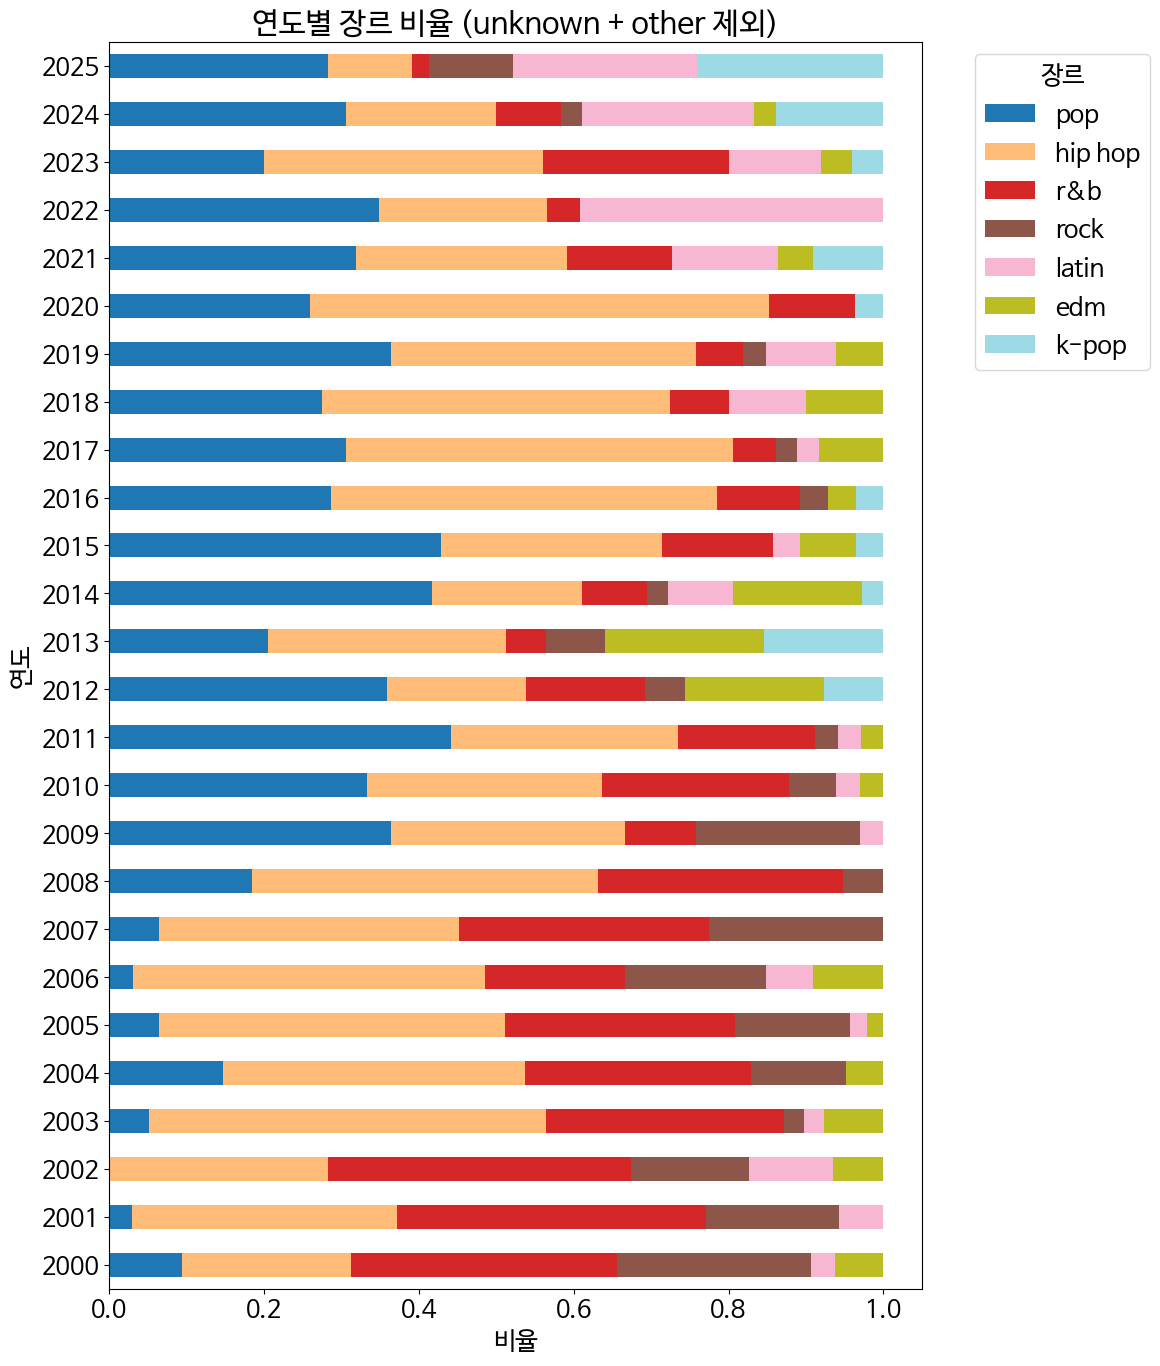

In [12]:
# 그래프에 표시할 장르 순서 지정
genre_order = ["pop", "hip hop", "r&b", "rock", "latin", "edm", "k-pop"]
genre_order = [g for g in genre_order if g in pivot.columns]

# 지정한 장르만 추출해 가로 누적 막대그래프용 데이터 구성
pivot_barh = pivot[genre_order]

# 가로 누적 막대 그래프
pivot_barh.plot(kind="barh",
                stacked=True,
                figsize=(12, 14),
                colormap="tab20")

plt.title("연도별 장르 비율 (unknown + other 제외)")
plt.xlabel("비율")
plt.ylabel("연도")
plt.legend(title="장르", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


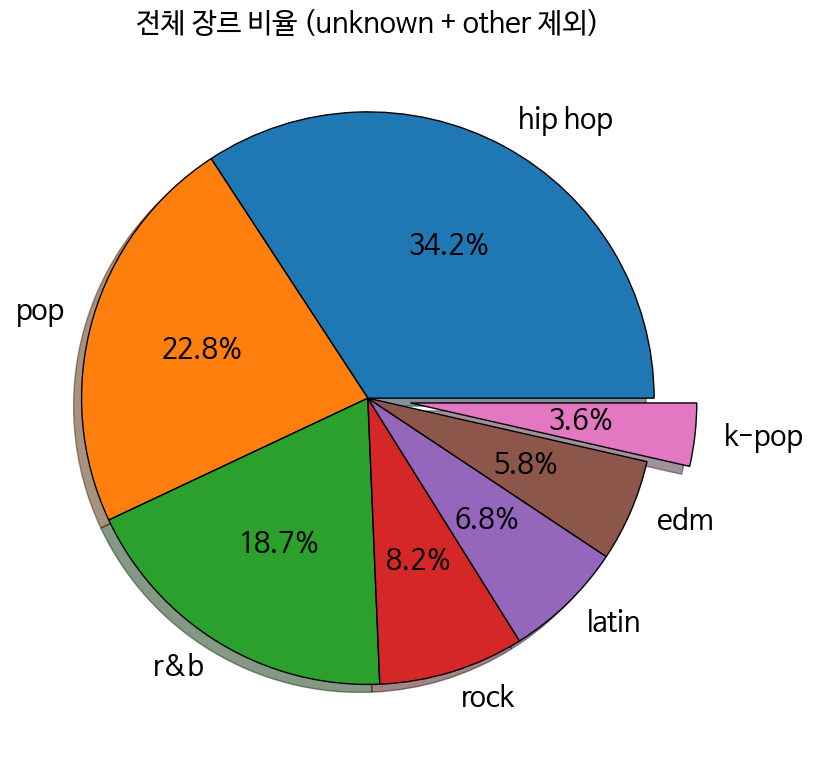

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 장르별 곡 수 계산
genre_counts = df_main["genre_coarse"].value_counts()
labels = genre_counts.index
sizes = genre_counts.values

# k-pop만 강조해서 분리 표시
explode = [0.15 if label == "k-pop" else 0 for label in labels]

# 파이 차트 그리기
plt.figure(figsize=(10, 8))

plt.pie(
    sizes,
    labels=labels,
    autopct="%.1f%%",       # 비율 표시
    shadow=True,
    wedgeprops={'edgecolor':'black', 'linewidth':1},
    textprops={'fontsize': 20},
    explode=explode
)

plt.title("전체 장르 비율 (unknown + other 제외)", fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
# 연도별 상위 1개 장르 찾기
top1_by_year = (
    year_genre
    .sort_values(["year", "ratio"], ascending=[True, False])  # 연도별로 비율 내림차순 정렬
    .groupby("year")
    .head(1)   # 각 연도에서 1행(=비율 1등)만 남기기
    .reset_index(drop=True)
)

top1_by_year[["year", "genre_coarse", "ratio", "year_total"]]


,year,genre_coarse,ratio,year_total
0,2000,r&b,0.375000,32
1,2001,r&b,0.400000,35
2,2002,hip hop,0.367347,49
3,2003,hip hop,0.500000,40
4,2004,hip hop,0.395349,43
5,2005,hip hop,0.456522,46
6,2006,hip hop,0.437500,32
7,2007,hip hop,0.387097,31
8,2008,hip hop,0.447368,38
9,2009,pop,0.363636,33


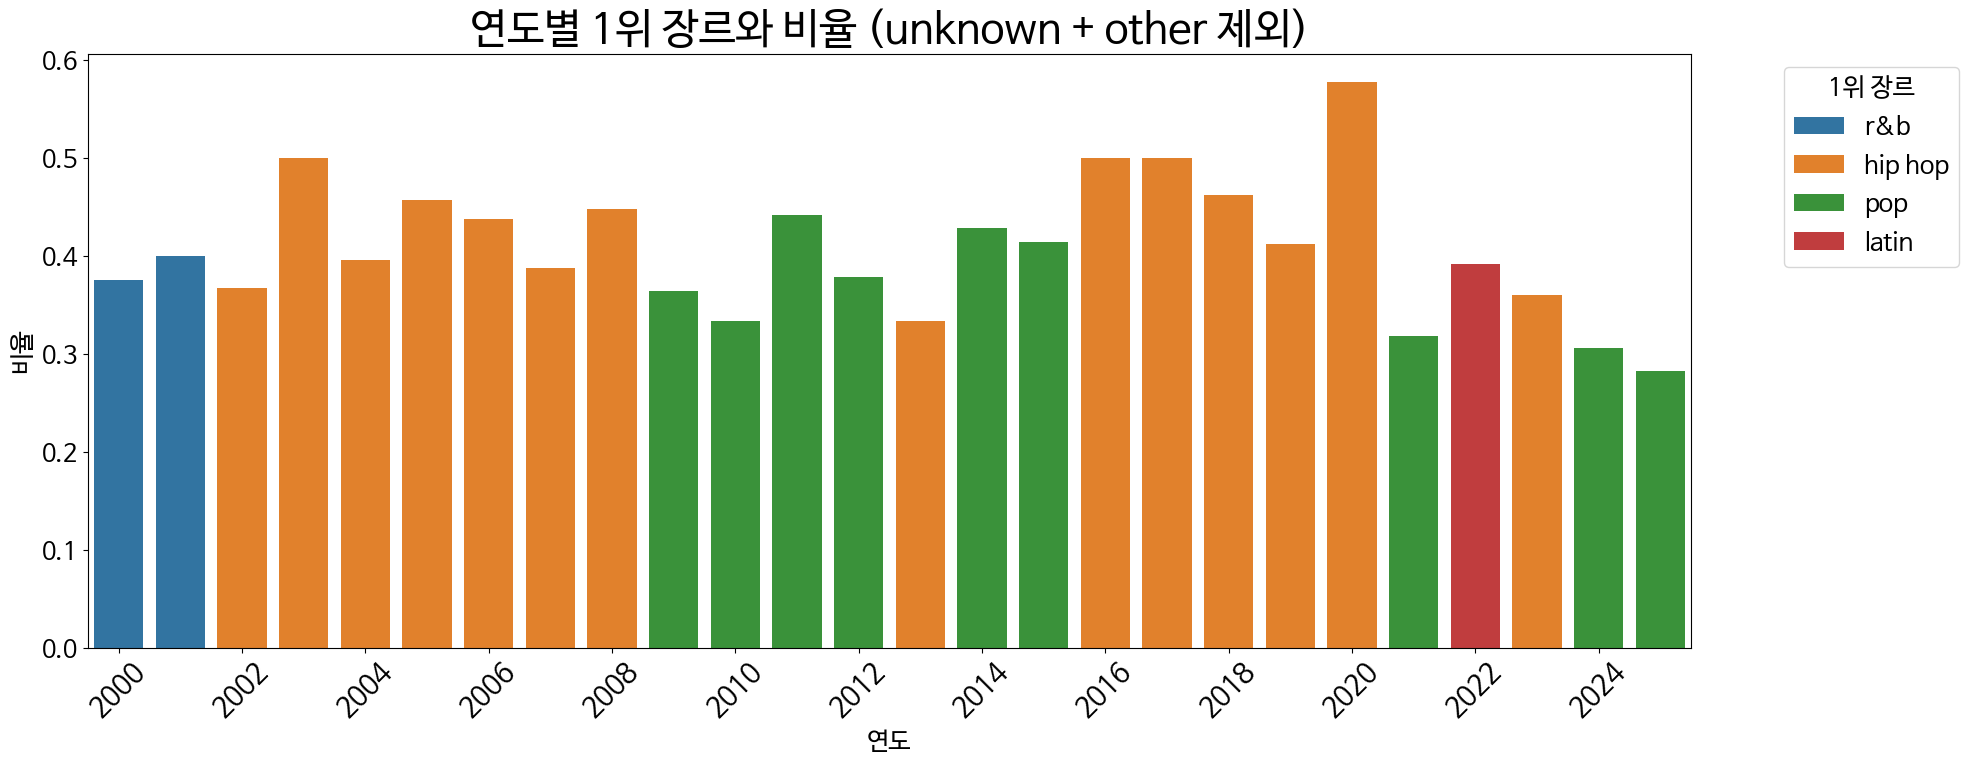

<Figure size 1800x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 8))

# 연도별 1위 장르 비율 막대그래프
sns.barplot(
    data=top1_by_year,
    x="year",
    y="ratio",
    hue="genre_coarse",
    palette="tab10"
)

plt.title("연도별 1위 장르와 비율 (unknown + other 제외)", fontsize=30)
plt.xlabel("연도")
plt.ylabel("비율")

plt.xticks(
    ticks=range(len(top1_by_year))[::2],
    labels=top1_by_year["year"][::2],
    rotation=45,
    fontsize=20
)



plt.legend(title="1위 장르", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.figure(figsize=(18, 6))
plt.subplots_adjust(bottom=0.2)

plt.show()


In [ ]:
# 연도별 상위 2개 장르
top2_by_year = (
    year_genre
    .sort_values(["year", "ratio"], ascending=[True, False])
    .groupby("year")
    .head(2)              # 각 연도에서 비율 상위 2개
    .reset_index(drop=True)
)

top2_by_year[["year", "genre_coarse", "ratio"]]


,year,genre_coarse,ratio
0,2000,r&b,0.375000
1,2000,hip hop,0.218750
2,2001,r&b,0.400000
3,2001,hip hop,0.371429
4,2002,hip hop,0.367347
5,2002,r&b,0.367347
6,2003,hip hop,0.500000
7,2003,r&b,0.325000
8,2004,hip hop,0.395349
9,2004,r&b,0.302326


In [ ]:
# 연도(행) × 장르(열) 형태로 상위 2개 장르 비율을 펼친 표

pivot_top2 = top2_by_year.pivot(
    index="year",
    columns="genre_coarse",
    values="ratio"
).fillna(0)

pivot_top2


genre_coarse,hip hop,k-pop,latin,pop,r&b
year,,,,,
2000,0.218750,0.00000,0.000000,0.000000,0.375000
2001,0.371429,0.00000,0.000000,0.000000,0.400000
2002,0.367347,0.00000,0.000000,0.000000,0.367347
2003,0.500000,0.00000,0.000000,0.000000,0.325000
2004,0.395349,0.00000,0.000000,0.000000,0.302326
2005,0.456522,0.00000,0.000000,0.000000,0.304348
2006,0.437500,0.00000,0.000000,0.000000,0.187500
2007,0.387097,0.00000,0.000000,0.000000,0.322581
2008,0.447368,0.00000,0.000000,0.000000,0.315789


<Figure size 1400x700 with 0 Axes>

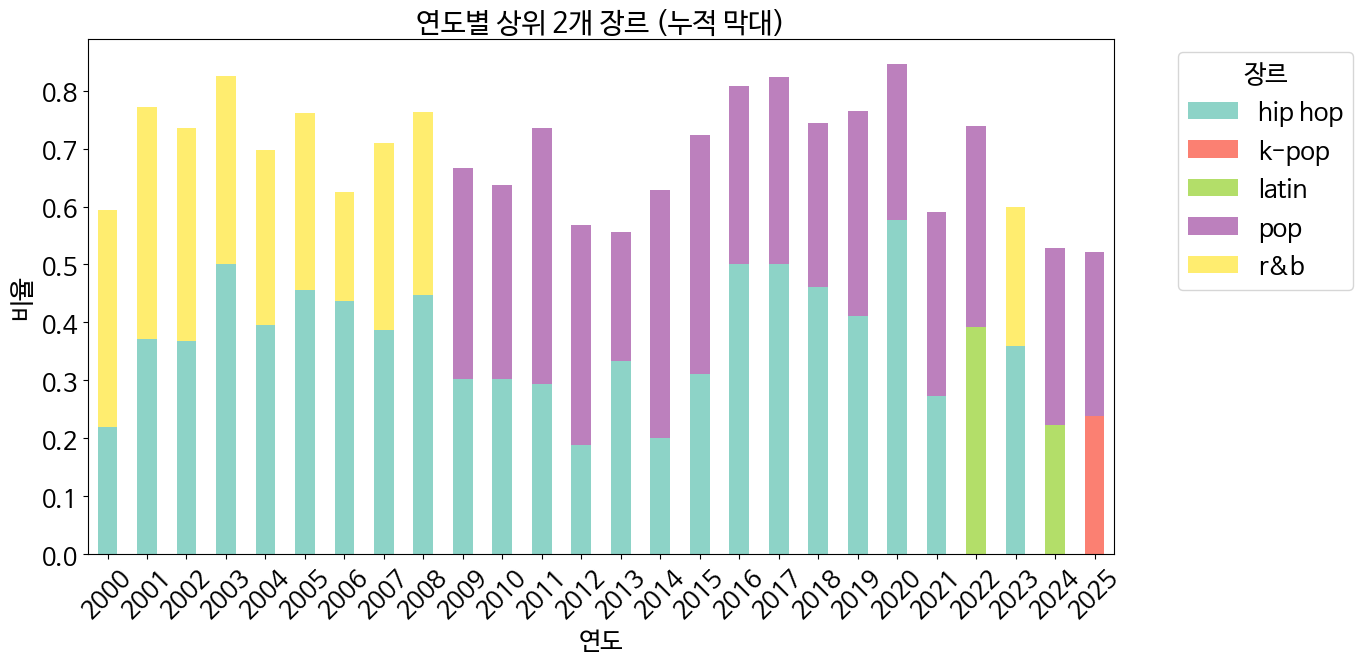

In [ ]:
import matplotlib.pyplot as plt


# 연도별 상위 2개 장르 비율을 누적 막대그래프로 시각화
plt.figure(figsize=(14, 7))

pivot_top2.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    cmap="Set3"
)

plt.title("연도별 상위 2개 장르 (누적 막대)", fontsize=20)
plt.xlabel("연도")
plt.ylabel("비율")

plt.xticks(rotation=45)
plt.legend(title="장르", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()


In [ ]:
# 연도별 K-pop 곡 수와 비율만 모아 보기
kpop_year = (
    year_genre[year_genre["genre_coarse"] == "k-pop"]
    .sort_values("year")
    [["year", "count", "year_total", "ratio"]]
)

kpop_year


,year,count,year_total,ratio
66,2012,2,37,0.054054
72,2013,5,36,0.138889
78,2014,1,35,0.028571
85,2015,1,29,0.034483
91,2016,1,26,0.038462
112,2020,1,26,0.038462
117,2021,2,22,0.090909
127,2023,1,25,0.040000
133,2024,5,36,0.138889
139,2025,11,46,0.239130


In [ ]:
# 전체 연도 목록 (2000~2025)
all_years = sorted(year_genre["year"].unique())

# 모든 연도를 데이터프레임 생성
kpop_full = pd.DataFrame({"year": all_years})

# 기존 K-pop 연도 데이터와 병합(없는 해는 NaN)
kpop_full = kpop_full.merge(
    kpop_year,
    on="year",
    how="left"
)

# K-pop이 없던 해는 0으로 채우기
kpop_full[["count", "ratio"]] = kpop_full[["count", "ratio"]].fillna(0)

kpop_full


,year,count,year_total,ratio
0,2000,0.0,NaN,0.000000
1,2001,0.0,NaN,0.000000
2,2002,0.0,NaN,0.000000
3,2003,0.0,NaN,0.000000
4,2004,0.0,NaN,0.000000
5,2005,0.0,NaN,0.000000
6,2006,0.0,NaN,0.000000
7,2007,0.0,NaN,0.000000
8,2008,0.0,NaN,0.000000
9,2009,0.0,NaN,0.000000


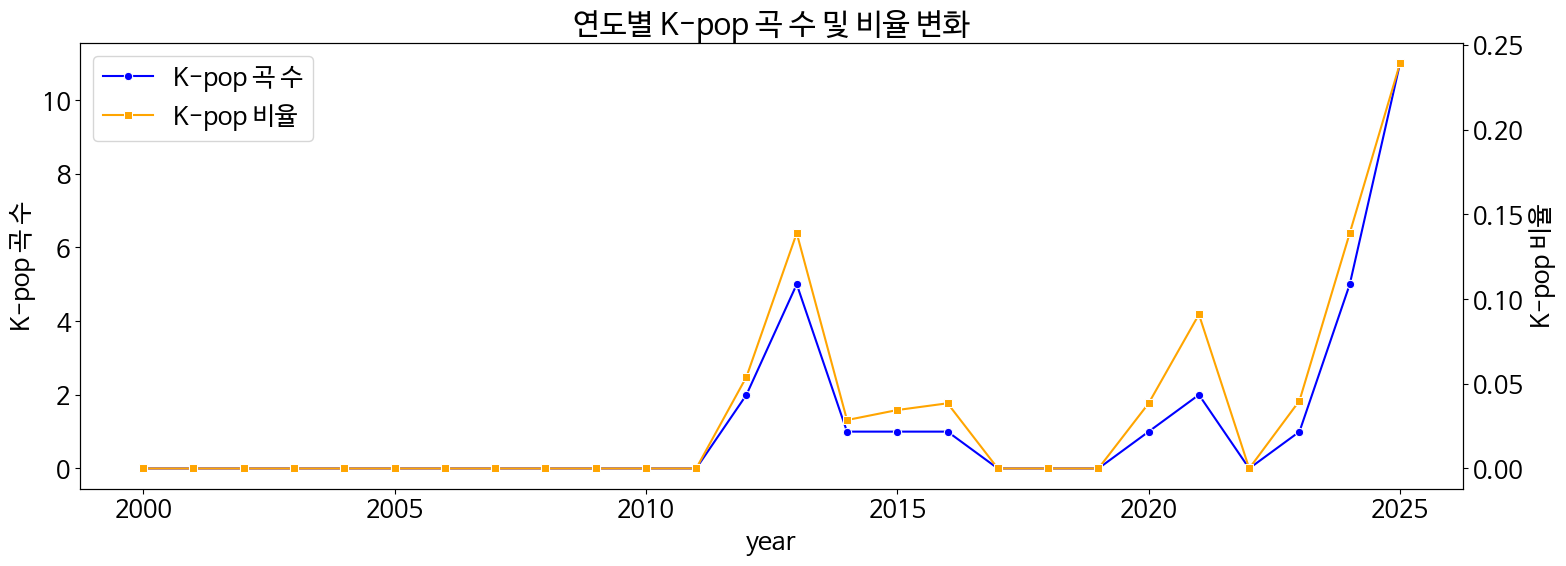

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

# 왼쪽 축: K-pop 곡 수
ax1 = sns.lineplot(
    data=kpop_full,
    x="year",
    y="count",
    marker="o",
    color="blue",
    label="K-pop 곡 수"
)

# 오른쪽 축: K-pop 비율
ax2 = ax1.twinx()
sns.lineplot(
    data=kpop_full,
    x="year",
    y="ratio",
    marker="s",
    color="orange",
    label="K-pop 비율",
    ax=ax2
)

# 오른쪽 축 범례 제거
ax2.legend([], [], frameon=False)

# 왼쪽 범례 하나로 통합
ax1.legend(handles=ax1.lines + ax2.lines,
           labels=["K-pop 곡 수", "K-pop 비율"],
           loc="upper left")

# 축 라벨 설정
ax1.set_ylabel("K-pop 곡 수")
ax2.set_ylabel("K-pop 비율")


plt.title("연도별 K-pop 곡 수 및 비율 변화")
plt.tight_layout()
plt.show()


In [ ]:
#K-pop 등장 연도
kpop_full[kpop_full["count"] > 0].head(1)


,year,count,year_total,ratio,ratio_diff
12,2012,2.0,37.0,0.054054,0.054054


In [ ]:
#K-pop 성장 시작 연도 찾기
kpop_full[kpop_full["ratio"] > 0.05]   #  5% 이상 찍은 해


,year,count,year_total,ratio,ratio_diff
12,2012,2.0,37.0,0.054054,0.054054
13,2013,5.0,36.0,0.138889,0.084835
21,2021,2.0,22.0,0.090909,0.052448
24,2024,5.0,36.0,0.138889,0.098889
25,2025,11.0,46.0,0.239130,0.100242
